In [1]:
import sys
import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'./')
# from importlib import reload

In [2]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='20gb',threads_per_worker=14,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(c)

/usr/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
from cov_3X2 import *
from lsst_utils import *

In [4]:
#only for python3
import importlib
reload=importlib.reload

In [5]:
zs=lsst_source_tomo_bins()

ns0:  27.0


# Power Spectrum covariance

In [6]:
#setup parameters
lmax_cl=5000
lmin_cl=2
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
lb=np.sqrt(l_bins[1:]*l_bins[:-1])

l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=True
bin_cl=True

SSV_cov=True
tidal_SSV_cov=False
Tri_cov=True

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

##  Test with 1 redshift bin

In [7]:
f_sky=0.35

In [8]:
z0=1 #1087
zs_bin1=source_tomo_bins(zp=[z0],p_zp=np.array([1]),ns=30,use_window=True,unit_win=True,f_sky=f_sky)

Win gen: step size 768


./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


cl dict done


In [9]:
zs_bin1[0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'AI', 'AI_z', 'mag_fact', 'lm', 'Gkernel', 'Gkernel_int', 'gkernel', 'gkernel_int', 'kernel_int', 'window', 'window_alm', 'window_alm_noise'])

10:01:18 WARNING:findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


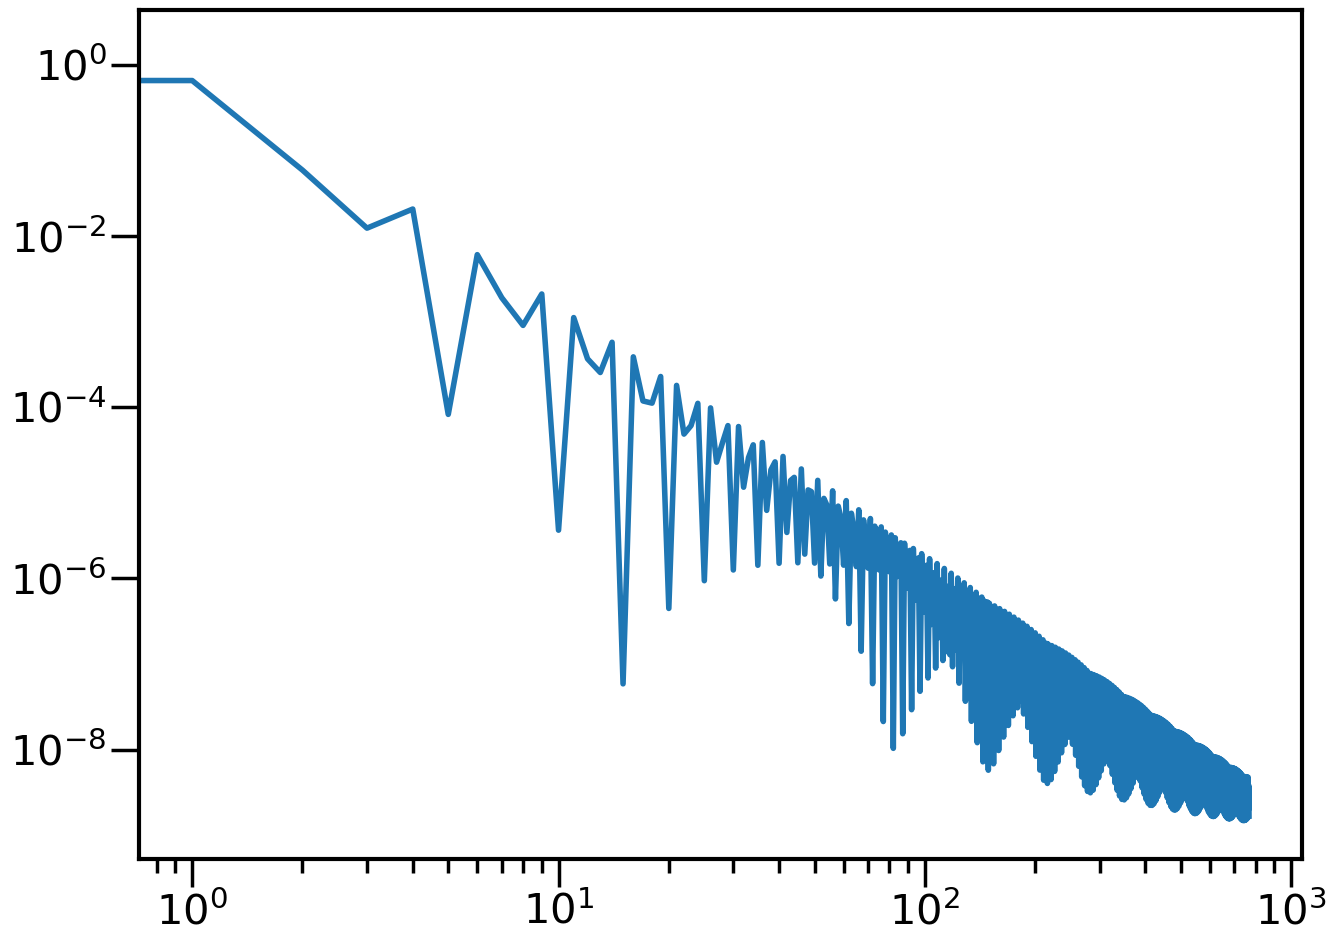

In [10]:
# loglog(zs_bin1[0]['window_cl'])
loglog(hp.alm2cl(zs_bin1[0]['window_alm']))

/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
10:01:18 WARNING:findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


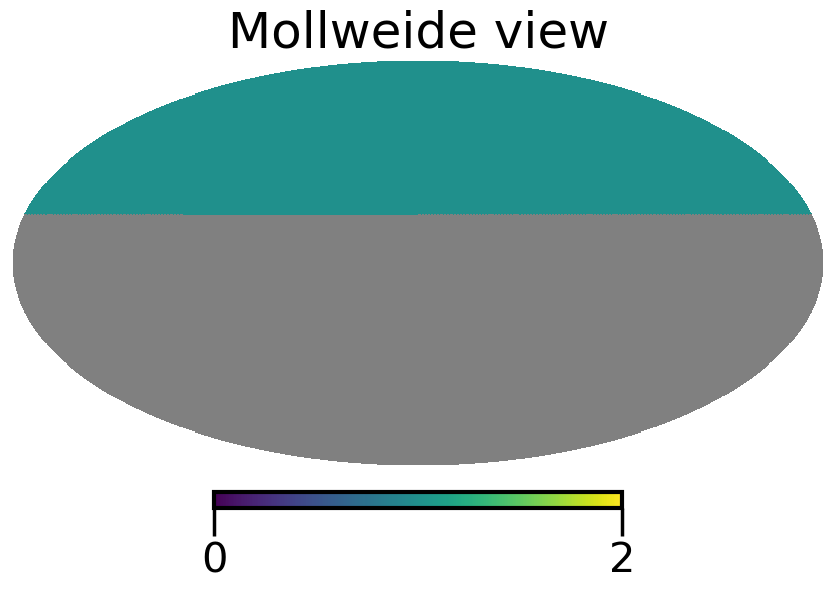

In [11]:
hp.mollview(zs_bin1[0]['window'])

In [12]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [13]:
# bin_cl=False
if not bin_cl:
    lb=l0
    l=l0

In [14]:
from astropy.cosmology import Planck15 as cosmo


In [15]:
import pyccl as ccl
cosmo_params={'h': 0.6774,
 'Omb': 0.0486,
 'Omd': 0.2589,
 's8': 0.817,
 'Om': 0.3075,
 'As': 2.12e-09,
 'mnu': 0.06,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'w': -1,
 'wa': 0,
 'Oml': 0.6925}

In [16]:
use_window=False

In [17]:
power_spectra_kwargs={'pk_func':'baryon_pk'}

In [18]:
#on nersc try /global/cscratch1/sd/sukhdeep/temp/
# only needed if you are playing with window calculations, kappa_win below
wigner_files={}
wigner_files[0]= 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr'
wigner_files[2]= 'temp/dask_wig3j_l6500_w1100_2_reorder.zarr'

In [19]:
#use all ell
kappa0=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=None,
                                       use_window=use_window,Tri_cov=Tri_cov,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
                                       )

#to test calculation using proper windows, in SSC.
kappa_win=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=None,
                                       use_window=True,Tri_cov=Tri_cov,store_win=True,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
                                       wigner_files=wigner_files)

Win gen: step size 807
Win gen: step size 807
wigner_files: {0: 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr', 2: 'temp/dask_wig3j_l6500_w1100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.206/23096/1' processes=1 cores=14>
got window cls, now to coupling matrices.
done coupling submatrix  0 7.907935857772827 0.3055136203765869 5.784429311752319
done coupling submatrix  807 8.654358386993408 0.9388954639434814 5.96340012550354
done coupling submatrix  1614 9.602661371231079 1.6220264434814453 6.227254390716553
done coupling submatrix  2421 10.840245723724365 2.5851123332977295 6.482634544372559
done coupling submatrix  3228 12.807953357696533 4.494272708892822 6.52549934387207


distributed.worker - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 17.38 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Worker is at 72% memory usage. Resuming worker. Process memory: 14.57 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 17.18 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Worker is at 69% memory usage. Resuming worker. Process memory: 13.92 GB -- Worker memory limit: 20.00 GB


done coupling submatrix  4035 16.05730938911438 5.806494951248169 8.511237859725952


distributed.worker - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 17.15 GB -- Worker memory limit: 20.00 GB
distributed.worker - WARNING - Worker is at 65% memory usage. Resuming worker. Process memory: 13.05 GB -- Worker memory limit: 20.00 GB


done coupling submatrix  4842 11.317099332809448 5.947265148162842 5.02305006980896


In [20]:
#get compute graphs
%time cl0G=kappa0.cl_tomo() 
%time cl0G_win=kappa_win.cl_tomo() 

cl dict done
CPU times: user 15.6 s, sys: 132 ms, total: 15.8 s
Wall time: 7.61 s
cl dict done
CPU times: user 15.6 s, sys: 145 ms, total: 15.8 s
Wall time: 7.52 s


In [ ]:
%time cl0=cl0G['stack'].compute()
%time cl0_win=cl0G_win['stack'].compute()
# %time clB=clBG['stack'].compute()

[4.58585244e-16 9.72005109e-16 1.33269396e-15 ... 5.40396202e-20
 5.40325311e-20 5.40254446e-20] [4.58585244e-16 9.72005109e-16 1.33269396e-15 ... 5.40396202e-20
 5.40325311e-20 5.40254446e-20] 1
0 True
True
2 True
True
4 True
True
CPU times: user 7.26 s, sys: 332 ms, total: 7.59 s
Wall time: 7.24 s
0 True
True
2 True
True
4 True
True


In [ ]:
corr2=kappa0.cov_utils.corr_matrix(cl0['cov'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

In [ ]:
# compute signal/noise
cov_inv=np.linalg.inv(cl0['cov'])
SN2=(np.dot(cl0['cl_b'],np.dot(cov_inv,cl0['cl_b'])))
np.sqrt(SN2)

In [ ]:
#again get Cl and cov, this time by referencing the particular bin
cl0={}
corr=('shear','shear')
%time cl0['cl0']=cl0G['cl'][corr][(0,0)].compute()
%time cl0['cl']=cl0G['cl_b'][corr].compute()
%time cl0['cov']=cl0G['cov'][corr+corr][(0,0,0,0)].compute()#kappa0.compute_cov_tomo(cl0G['cov'])

In [ ]:
#again get Cl and cov, this time by referencing the particular bin
cl0_win={}
corr=('shear','shear')
%time cl0_win['cl0']=cl0G_win['cl'][corr][(0,0)].compute()
%time cl0_win['cl']=cl0G_win['cl_b'][corr].compute()
%time cl0_win['cov']=cl0G_win['cov'][corr+corr][(0,0,0,0)].compute()#kappa0.compute_cov_tomo(cl0G['cov'])

In [ ]:
corr2=kappa0.cov_utils.corr_matrix(cl0['cov']['final_b'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

In [ ]:
corr2=kappa0.cov_utils.corr_matrix(cl0['cov']['final_b'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

In [ ]:
corr2=kappa0.cov_utils.corr_matrix(cl0['cov']['G_b']+cl0['cov']['Tri_b'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

In [ ]:
corr2=kappa0.cov_utils.corr_matrix(cl0['cov']['SSC_b'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

In [ ]:
cl_t=cl0['cl'][(0,0)]
plot(lb,cl_t)
# hlines(1,1,2000)
xscale('log')
yscale('log')
xlabel('$\ell$')
ylabel('$C_\ell$')
show()

In [ ]:
kappa0.cov_utils.Om_W

In [ ]:
cov0=cl0['cov']#[(0,0,0,0)]
cov0_win=cl0_win['cov']#[(0,0,0,0)]

f=1e4
plot(lb,np.diag(cov0['G_b'])/cl_t**2*f,label='Gaussian')
plot(lb,np.diag(cov0['SSC_b'])/cl_t**2*f,label='SSC')
plot(lb,np.diag(cov0['Tri_b'])/cl_t**2*f,label='Tri')
plot(lb,np.diag(cov0_win['SSC_b'])/cl_t**2*f,label='SSC_win')
# plot(lb,np.diag(cov0['SSC_dk'])/cl_t**2*f)
xscale('log')
yscale('log')
xlim(20,3000)
xlabel(r'$\ell$')
ylabel(r'$\frac{\delta C_\ell^2}{C_\ell^2}\times'+str(f)+'$')
legend()

In [ ]:
plot(kappa0.cov_utils.window_l,kappa0.cov_utils.Win**2,'--')
plot(hp.alm2cl(zs_bin1[0]['window_alm']))
loglog()
ylim(.0001,10)